In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn import svm

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [85]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/Titanic dataset/train.csv')

In [86]:
def group_age_range(data):
  age = data['Age']
  if 0 < age <= 16:
    return 'child'
  elif 16 < age <= 30 or pd.isna(age):
    return 'young adult'
  elif 30 < age <= 45:
    return 'middle aged adult'
  else:
    return 'old aged adult'

In [87]:
def fillMissingAgeValueByNameTitles(X):
    X['Initial']=0
    for i in X:
        X['Initial']= X.Name.str.extract('([A-Za-z]+)\.') # name title initial
        
    X['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)
    
    X.loc[(X.Age.isnull())&(X.Initial=='Mr'),'Age']=33
    X.loc[(X.Age.isnull())&(X.Initial=='Mrs'),'Age']=37
    X.loc[(X.Age.isnull())&(X.Initial=='Master'),'Age']=5
    X.loc[(X.Age.isnull())&(X.Initial=='Miss'),'Age']=22
    X.loc[(X.Age.isnull())&(X.Initial=='Other'),'Age']=46
    
fillMissingAgeValueByNameTitles(df)

In [88]:
df['Age_group'] = df.apply(group_age_range,1)

In [89]:
df['Family_Size']=df['SibSp']+df['Parch']

In [90]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].value_counts().idxmax())

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Initial      891 non-null    object 
 13  Age_group    891 non-null    object 
 14  Family_Size  891 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 104.5+ KB


In [92]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_group,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,young adult,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,middle aged adult,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,young adult,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,middle aged adult,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,middle aged adult,0


In [7]:
df[df['Survived'] == 1].groupby(['Sex'])['Survived'].count()

Sex
female    233
male      109
Name: Survived, dtype: int64

In [8]:
woman_rate = df['Sex'][df['Sex'] == 'female'][df['Survived'] == 1].count()/df['Sex'][df['Sex'] == 'female'].count()
print('Survival rate of woman: ', woman_rate) 
man_rate = df['Sex'][df['Sex'] == 'male'][df['Survived'] == 1].count()/df['Sex'][df['Sex'] == 'male'].count()
print('Survival rate of man: ', man_rate)

Survival rate of woman:  0.7420382165605095
Survival rate of man:  0.18890814558058924


In [9]:
def func(group):
    num_survival = group['Survived'].sum()
    total = group['Survived'].count()
    survival_rate = group['Survived'].sum()/group['Survived'].count()
    return pd.Series([num_survival, total, survival_rate], index=['num_survival', 'total' ,'survival_rate'])

df.groupby(['Sex','Pclass']).apply(func)

num_survival  total  survival_rate
Sex    Pclass                                    
female 1               91.0   94.0       0.968085
       2               70.0   76.0       0.921053
       3               72.0  144.0       0.500000
male   1               45.0  122.0       0.368852
       2               17.0  108.0       0.157407
       3               47.0  347.0       0.135447

In [17]:
d = df.groupby(['Sex','Age']).apply(func)

<Figure size 432x288 with 0 Axes>

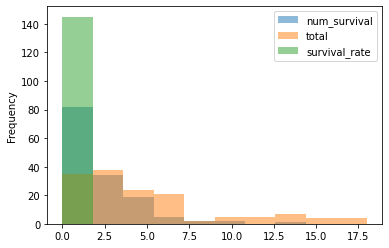

In [11]:
plt.figure();
d.plot.hist(alpha=0.5);

In [29]:
age_fare = df[['Age','Fare','Pclass']]

In [32]:
x

,Age,Fare,Pclass
803,0.42,8.5167,3
755,0.67,14.5000,2
644,0.75,19.2583,3
469,0.75,19.2583,3
78,0.83,29.0000,2
...,...,...,...
859,NaN,7.2292,3
863,NaN,69.5500,3
868,NaN,9.5000,3
878,NaN,7.8958,3


In [30]:
x = age_fare.sort_values(by=['Age'])

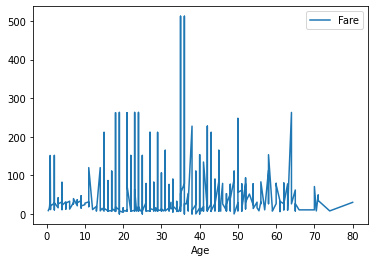

In [31]:
x.plot.line(x = 'Age',y = 'Fare')

In [231]:
# column_transform = make_column_transformer((OneHotEncoder(),['Sex','Age_group']),
#                                            (OrdinalEncoder(),['Family_Size','Pclass']))
column_transform = make_column_transformer((OneHotEncoder(),['Sex','Age_group','Embarked']),
                                           (OrdinalEncoder(),['Parch','SibSp','Pclass']))
X = column_transform.fit_transform(df)

In [232]:
Y = df['Survived'].values

In [233]:
X.shape

(891, 12)

Naive Bayes


In [130]:
NB = BernoulliNB()
NB_pipeline = make_pipeline(column_transform, NB)

In [137]:
NB.fit(X,Y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [138]:
pr = NB.predict(X)

In [139]:
accuracy_score(Y, pr)

0.7845117845117845

Support Vector Machine

In [234]:
SVM = svm.SVC()
SVM.fit(X,Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [235]:
pr = SVM.predict(X)
accuracy_score(Y, pr)

0.8406285072951739

In [142]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2)
model.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [143]:
pr = model.predict(X)
print(classification_report(Y, pr))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       549
           1       0.79      0.67      0.73       342

    accuracy                           0.81       891
   macro avg       0.80      0.78      0.79       891
weighted avg       0.81      0.81      0.80       891



Multilayer Perceptron 

In [144]:
MLP = MLPClassifier(max_iter=500,hidden_layer_sizes=(128,128,128))
MLP.fit(X,Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(128, 128, 128), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [145]:
pr = MLP.predict(X)
accuracy_score(Y, pr)

0.8630751964085297

In [146]:
print(classification_report(Y, pr))

              precision    recall  f1-score   support

           0       0.84      0.95      0.90       549
           1       0.91      0.72      0.80       342

    accuracy                           0.86       891
   macro avg       0.88      0.84      0.85       891
weighted avg       0.87      0.86      0.86       891



KERAS Deep Neural network

In [192]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [198]:
model = Sequential()
model.add(Dense(128, input_dim=11, activation="relu"))
model.add(Dropout(0.3)) 
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))  
model.add(Dense(128, activation="relu")) 
model.add(Dense(1, activation="sigmoid"))
model.compile(
  loss="binary_crossentropy",
  optimizer='adam',
  metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 128)               1536      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 129       
Total params: 34,689
Trainable params: 34,689
Non-trainable params: 0
_________________________________________________

In [199]:
# fit the keras model on the dataset
model.fit(X,Y, epochs=150)

Epoch 1/150
28/28 [==============================] - 1s 2ms/step - loss: 0.6193 - accuracy: 0.6566
Epoch 2/150
28/28 [==============================] - 0s 2ms/step - loss: 0.5018 - accuracy: 0.7778
Epoch 3/150
28/28 [==============================] - 0s 2ms/step - loss: 0.4687 - accuracy: 0.8002
Epoch 4/150
28/28 [==============================] - 0s 2ms/step - loss: 0.4616 - accuracy: 0.7856
Epoch 5/150
28/28 [==============================] - 0s 3ms/step - loss: 0.4523 - accuracy: 0.8103
Epoch 6/150
28/28 [==============================] - 0s 3ms/step - loss: 0.4352 - accuracy: 0.8103
Epoch 7/150
28/28 [==============================] - 0s 2ms/step - loss: 0.4326 - accuracy: 0.8171
Epoch 8/150
28/28 [==============================] - 0s 2ms/step - loss: 0.4357 - accuracy: 0.8171
Epoch 9/150
28/28 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.8058
Epoch 10/150
28/28 [==============================] - 0s 2ms/step - loss: 0.4236 - accuracy: 0.8215
Epoch 11/

----------------Test---------------------


In [236]:
dt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/Titanic dataset/test.csv')

In [237]:
fillMissingAgeValueByNameTitles(dt)

In [239]:
dt['Age_group'] = dt.apply(group_age_range,1)
dt['Family_Size']=dt['SibSp']+dt['Parch']
dt['Embarked'] = dt['Embarked'].fillna(df['Embarked'].value_counts().idxmax())

In [240]:
X_test = column_transform.fit_transform(dt)

In [21]:
my_pr = NB.predict(X_test)

In [241]:
my_pr = SVM.predict(X_test)

In [151]:
my_pr = MLP.predict(X_test)

DNN from Keras

In [222]:
my_pr = model.predict(X_test)
my_pr = np.round(my_pr).astype(int)

Export result to csv file

In [242]:
re = pd.DataFrame()

In [243]:
re['PassengerId'] = dt['PassengerId']
re['Survived'] = pd.DataFrame(my_pr)

In [244]:
re

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [245]:
re.to_csv('myPredict.csv',index=False)